# Case Study

Jack Dean, Charles Dotson, and Rodrigo Petricioli  
ISE 447 - Financial Optimization  
Lehigh Univerisity

In [391]:
'''
Package Imports
'''
import pandas as pd
import numpy as np
import pulp
from pulp import *
import datetime
import matplotlib.pyplot as plt

import FinOpsCodeDeck as finops

from IPython.display import Markdown as md
# %matplotlib widget


## Provided Data

A municipality sends the following liability stream (in millions of dollars)

| Date Due | Amount |  
| -- | -- |
| 12/15/2022 | 11 |  
|  6/15/2023 |  9 |  
| 12/15/2023 |  8 |  
|  6/15/2024 |  7 |  
| 12/15/2024 |  9 |  
|  6/15/2025 | 10 |  
| 12/15/2025 |  9 |  
|  6/15/2026 | 12 |  
| 12/15/2026 |  9 |  
|  6/15/2027 |  6 |  
| 12/15/2027 |  5 |  
|  6/15/2028 |  7 |  
| 12/15/2028 |  9 |  
|  6/15/2029 |  7 |  
| 12/15/2029 |  8 |  
|  6/15/2030 |  7 |  



## Problem 1

Determine the current term structure of treasury rates (see textbook Section 3.4 or other resources that you can find), and find the present value, duration, and convexity of the stream of liabilities. Please explain the main steps followed in your calculations.  Use real world data.

In [392]:
'''
Data Import for Current Term Structure
---
Imports all active treasury bonds data, time indexes them by year
'''

data_prompt = pd.read_excel('Table.xlsx', sheet_name='PromptUse', index_col = 'DateDue')
data_prompt = data_prompt/1000

term_structure_df = pd.read_excel('TableNew.xlsx', sheet_name='d')
term_structure_df['px_ask'] = [i if i>=5 else 100 - i for i in term_structure_df['ASKED'].to_list()]
term_structure_df['px_bid'] = [i if i>=5 else 100 - i for i in term_structure_df['BID'].to_list()]
term_structure_df['ttm'] = [(i - datetime.datetime.now())/datetime.timedelta(days=365) for i in term_structure_df['MATURITY']]

In [393]:
'''
Bootstrap yield curve
---
begins with zero-coupon bonds to payout (ttm < 0.5 yrs) & calculates yield
moves to coupon bonds and uses calculated yields to bootstrap further
sorts all bonds into data frame indexed by ttm (by 100th of a year)
NOTE: Averages yields for the same time period
NOTE: assumes yield of period prior if yield for desired period does not exist
'''

'''short term rates'''
mats = []
round_to = 2
for bond_tenor in term_structure_df[term_structure_df['ttm'] <= 0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    cpn = bond['COUPON']/2
    ttm = bond['ttm']
    px = bond['px_ask']
    mats.append([np.round(ttm,round_to),np.log((100 + cpn) / bond['px_ask']) / bond['ttm']])
rates = pd.DataFrame(mats, columns=['ttm','rate']).set_index('ttm').groupby('ttm').mean()

'''longer term rates'''
for bond_tenor in term_structure_df[term_structure_df['ttm']>=0.5].index:
    bond = term_structure_df.loc[bond_tenor]
    px = bond['px_ask']
    ttm = bond['ttm']
    cpn = bond['COUPON']/2
    pmts = int(np.ceil(ttm * 2))
    cfs = [cpn if i+1<pmts else 100 + cpn for i in range(pmts)]
    cfs_idx = [np.round(ttm-i*0.5, round_to) for i in reversed(range(pmts))]
    known_rates = [rates[:cfs_idx[i]].iloc[-1,0] for i in range(pmts-1)]
    val = px - sum([cpn * np.exp((-1) * known_rates[i] * cfs_idx[i]) for i in range(pmts-1)])
    yld = (-1) * (np.log(val / (100+cpn)) / cfs_idx[pmts-1])
    add_df = pd.DataFrame([np.round(ttm, round_to), yld], index=['ttm','rate']).transpose().set_index('ttm')
    rates = pd.concat([rates,add_df],ignore_index=False)
    rates = rates.groupby('ttm').mean()

Text(0, 0.5, 'Yield in Percentage Points')

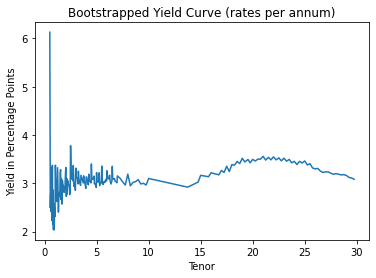

In [394]:
'''
plot yield curve
---
plots yield curve in percentage points
'''
plt.plot(rates[0.5:] * 100)
plt.title('Bootstrapped Yield Curve (rates per annum)')
plt.xlabel('Tenor')
plt.ylabel('Yield in Percentage Points')

In [395]:
# data_prompt = pd.read_excel('Table.xlsx', sheet_name='PromptUse', index_col = 'DateDue')
data_prompt['ttm'] = np.round((data_prompt.index - datetime.datetime.now()) / datetime.timedelta(days=365), round_to)

r = []
for ttm in data_prompt['ttm']:
    r.append(rates[:ttm].iloc[-1,0])
data_prompt['rates'] = r

npv = sum([data_prompt.iloc[i,0]*np.exp((-1)*data_prompt.iloc[i,1]*data_prompt.iloc[i,2]) for i in range(len(data_prompt))])
dur = sum([data_prompt.iloc[i,0]*data_prompt.iloc[i,1]*np.exp((-1) * (data_prompt.iloc[i,1]+1)*data_prompt.iloc[i,2]) for i in range(len(data_prompt))])
con = sum([data_prompt.iloc[i,0]*data_prompt.iloc[i,1]*(data_prompt.iloc[i,1]+1)*np.exp((-1)*(data_prompt.iloc[i,1]+2)*data_prompt.iloc[i,2]) for i in range(len(data_prompt))])

print('The Net Present Value of the Liabilities is ${:.2f} million dollars'.format(npv))
print('The Macauley Duration of the Liability stream is {:.2f} years'.format(dur/npv))
print('The Convexity of the Liability stream is {:.2f}'.format(con/npv))

The Net Present Value of the Liabilities is $117.49 million dollars
The Macauley Duration of the Liability stream is 3.83 years
The Convexity of the Liability stream is 23.31


In [396]:
# Using markdown outputs instead of just printing

md('''
<center>

### Solutions

The Net Present Value of the Liabilities is $\${:.2f}$ MM

The Macauley Duration of the Liability stream is ${:.2f}$ years

The Convexity of the Liability stream is ${:.2f}$


'''.format(npv,dur/npv,con/npv))



<center>

### Solutions

The Net Present Value of the Liabilities is $\$117.49$ MM

The Macauley Duration of the Liability stream is $3.83$ years

The Convexity of the Liability stream is $23.31$




## Problem 2

Identify *at least* 30 fixed-income assets that are suitable to construct a dedicated bond portfolio for the municipality liabilities that you have been given. Use assets that are considered risk-free; for example, US government non-callable treasury bonds, treasury bills, or treasury notes. Display in an appropriate table the main characteristics of the bonds you choose. Namely, prices, coupon rates, maturity dates, face value).

In [397]:
ref_data = ['T ' + str(term_structure_df.iloc[bond,1]) + ' ' + term_structure_df.iloc[bond,0].strftime('%m/%d/%y') for bond in term_structure_df.index]
term_structure_df['ref_data'] = ref_data

bonds_clean = term_structure_df[['ref_data', 'px_ask', 'ASKED YIELD']]
bonds_clean.columns = ['Bond', 'Price', 'Yield']
bonds_clean = bonds_clean.set_index('Bond')


In [398]:
bonds_clean

,Price,Yield
Bond,,
T 1.75 05/15/22,100.010,-1.9931
T 2.125 05/15/22,100.012,-2.5447
T 0.0 05/17/22,99.352,0.6570
T 0.0 05/19/22,99.340,0.6690
T 0.0 05/24/22,99.320,0.6900
...,...,...
T 1.875 02/15/51,75.310,3.1520
T 2.375 05/15/51,85.156,3.1410
T 2.0 08/15/51,78.106,3.1370


In [399]:
term_structure_df

,MATURITY,COUPON,BID,ASKED,ASKED YIELD,px_ask,px_bid,ttm,ref_data
0,2022-05-15,1.750,100.004,100.010,-1.9931,100.010,100.004,-0.002567,T 1.75 05/15/22
1,2022-05-15,2.125,100.006,100.012,-2.5447,100.012,100.006,-0.002567,T 2.125 05/15/22
2,2022-05-17,0.000,0.658,0.648,0.6570,99.352,99.342,0.002913,T 0.0 05/17/22
3,2022-05-19,0.000,0.670,0.660,0.6690,99.340,99.330,0.008392,T 0.0 05/19/22
4,2022-05-24,0.000,0.690,0.680,0.6900,99.320,99.310,0.022091,T 0.0 05/24/22
...,...,...,...,...,...,...,...,...,...
359,2051-02-15,1.875,75.290,75.310,3.1520,75.310,75.290,28.772776,T 1.875 02/15/51
360,2051-05-15,2.375,85.136,85.156,3.1410,85.156,85.136,29.016611,T 2.375 05/15/51
361,2051-08-15,2.000,78.086,78.106,3.1370,78.106,78.086,29.268666,T 2.0 08/15/51
362,2051-11-15,1.875,75.314,76.014,3.1240,76.014,75.314,29.520721,T 1.875 11/15/51


## Problem 3

Formulate a linear programming model to find the lowest cost bond dedicated portfolio that covers the stream of liabilities. To eliminate the possibility of any interest risk, assume that a 0% reinvestment rate on cash balances carried out from one date to the next. Assume no short selling of bonds is allowed. What is the cost of your portfolio? How does this cost compares with the NPV of the liabilities? What is the composition of the portfolio?

### Mathematical Formulation

$$
\begin{split}
\text{min} \ \ \ &  z_0 + \sum_{i=1}^NP_ix_i \\
\text{s.t.} \ \ \ & \sum_{i=1,...,n:M_i \ge t-1}C_ix_i + \sum_{i=1,...,n:M_i \ge t}100x_i + z_{t-1} -z_t = L_t\\
& \text{All variables are non-negative} \\
\end{split}
$$

In [400]:
'''
Data Manipulation
'''
term_by_maturity = term_structure_df.set_index('MATURITY')
possibilities = term_by_maturity.drop(
    index=[i for i in term_by_maturity.index.to_list() if i > data_prompt.index.to_list()[-1]],
    columns=['BID', 'ASKED', 'ASKED YIELD']
    )

'''List of bond maturities less than liability maturity'''
date_lists_to_change_to_periods = [
    [i for i in possibilities.index.to_list() if i <= t]
    for t in data_prompt.index.tolist()
    ]
'''Removing the duplicates from each one'''
for i in reversed(range(1,len(date_lists_to_change_to_periods))):
    for j in range(0,len(date_lists_to_change_to_periods[i-1])):
        date_lists_to_change_to_periods[i].remove(date_lists_to_change_to_periods[i-1][j])

for i in range(0,len(date_lists_to_change_to_periods)):
    possibilities.loc[date_lists_to_change_to_periods[i],'period'] = i+1

possibilities['face'] = 100
possibilities['bond#'] = range(1,len(possibilities)+1)
possibilities = possibilities.set_index('bond#')

'''for labeling later'''
dec_var_names = possibilities['ref_data']

In [401]:
possibilities

,COUPON,px_ask,px_bid,ttm,ref_data,period,face
bond#,,,,,,,
1,1.750,100.010,100.004,-0.002567,T 1.75 05/15/22,1.0,100
2,2.125,100.012,100.006,-0.002567,T 2.125 05/15/22,1.0,100
3,0.000,99.352,99.342,0.002913,T 0.0 05/17/22,1.0,100
4,0.000,99.340,99.330,0.008392,T 0.0 05/19/22,1.0,100
5,0.000,99.320,99.310,0.022091,T 0.0 05/24/22,1.0,100
...,...,...,...,...,...,...,...
285,6.125,120.284,120.274,7.254967,T 6.125 08/15/29,15.0,100
286,1.750,92.076,92.066,7.507022,T 1.75 11/15/29,15.0,100
287,1.500,90.076,90.066,7.759077,T 1.5 02/15/30,16.0,100


In [402]:
'''Getting data ready for the solver'''

'''Empty Array'''
cfs = np.zeros((len(possibilities),len(date_lists_to_change_to_periods)))

'''CF Matrix'''
'''Will make function later'''
for i in range(0, len(cfs)):
    for j in range(1, len(cfs[0])+1):
        if possibilities.loc[i+1,'period'] == j and possibilities.loc[i+1,'COUPON'] == 0:
            cfs[i][j-1] = possibilities.loc[i+1,'face']
        elif possibilities.loc[i+1,'period'] == j and possibilities.loc[i+1,'COUPON'] != 0:
            cfs[i][0:j-1] = possibilities.loc[i+1,'COUPON']/2
            cfs[i][j-1] = possibilities.loc[i+1,'face'] + possibilities.loc[i+1,'COUPON']/2

cf_matrix = cfs.tolist()
prices = possibilities['px_ask'].values.tolist()
liabilities = data_prompt['Amount'].values.tolist()

In [403]:
'''
Solves dediticated portfolio
'''
periods = [i for i in range(0,len(cf_matrix[0])+1)]
qs = LpVariable.dicts('',dec_var_names,lowBound=0)
excess = LpVariable.dicts('ExcessCf', periods, lowBound=0)

ded_t = LpProblem('Dedication', LpMinimize)

ded_t += lpSum([cf_df['px_ask'][i] * qs[i] for i in dec_var_names]+ excess[0]) 

for i in range(0,len(cf_matrix[0])):
    ded_t += lpSum([cf_df[i][j]*qs[j] for j in dec_var_names]) + excess[i]- excess[i+1] == liabilities[i]

ded_t.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/6429d1e0aa2b4269935284514a7ea882-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/6429d1e0aa2b4269935284514a7ea882-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 21 COLUMNS
At line 1892 RHS
At line 1909 BOUNDS
At line 1910 ENDATA
Problem MODEL has 16 rows, 306 columns and 1580 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 16 (0) rows, 161 (-145) columns and 1116 (-464) elements
0  Obj 0 Primal inf 1.2901585 (16)
31  Obj 117.77454
Optimal - objective value 117.77454
After Postsolve, objective 117.77454, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 117.7745377 - 31 iterations time

1

In [404]:
'''Solving for the dedicated portfolio'''

# Making variable list of strings
periods = [i for i in range(0,len(cf_matrix[0])+1)]

# Dictionary of period constraints
period_dict = {}
for i in range(0,len(cf_matrix[0])):
    period_dict['Period {}'.format(i+1)] = dict(zip(dec_var_names,[cf_matrix[j][i] for j in range(0,len(cf_matrix))]))

objective = dict(zip(dec_var_names, prices))

# Decision Vars
quantity = LpVariable.dict('', dec_var_names, lowBound=0)
excess = LpVariable.dict('carryover', periods, lowBound=0)

# Intializing the Problem
dedication_1 = LpProblem('Dedicated', LpMinimize)

# Objective function
dedication_1 += excess[0]+lpSum([objective[i]*quantity[i] for i in dec_var_names])

# Constraints
for i in range(0,len(cf_matrix[0])):
    dedication_1 += lpSum([period_dict['Period {}'.format(i+1)][j]*quantity[j] for j in dec_var_names]) + excess[i]- excess[i+1] == liabilities[i]

dedication_1.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/3fc6b40177b0475e9139e2ab8ef49ff3-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/3fc6b40177b0475e9139e2ab8ef49ff3-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 21 COLUMNS
At line 1892 RHS
At line 1909 BOUNDS
At line 1910 ENDATA
Problem MODEL has 16 rows, 306 columns and 1580 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 16 (0) rows, 161 (-145) columns and 1116 (-464) elements
0  Obj 0 Primal inf 1.2901585 (16)
31  Obj 117.77454
Optimal - objective value 117.77454
After Postsolve, objective 117.77454, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 117.7745377 - 31 iterations time

1

In [405]:
composition = pd.DataFrame(
    [v.varValue for v in dedication_1.variables() if v.name[0] != 'c' and v.varValue > 0],
    index=[v.name[1:] for v in dedication_1.variables() if v.name[0] != 'c' and v.varValue > 0],
    columns=['Quantity']
    )

# Just have to match bonds with the tickers Jack created instead
'''Printing Solutions'''
md(''' 

##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \${:.2f} $ MM <br>

</center>

<center>

{}
'''.format(dedication_1.objective.value(),composition.to_markdown(colalign = ("right",))))

 

##### <center> Dedication Portfolio Cost & Composition  </center>

<center>

Portfolio Cost $ = \$117.77 $ MM <br>

</center>

<center>

|                  |   Quantity |
|-----------------:|-----------:|
| T_0.625_05_15_30 |  0.0697819 |
|  T_0.75_05_31_26 |  0.107674  |
|  T_1.25_05_31_28 |  0.0637436 |
|   T_1.5_11_30_24 |  0.0714316 |
|   T_2.0_05_31_24 |  0.0509223 |
| T_2.875_04_30_29 |  0.0664559 |
|   T_5.5_08_15_28 |  0.084142  |
| T_6.125_08_15_29 |  0.0774112 |
|  T_6.25_08_15_23 |  0.0590762 |
| T_6.375_08_15_27 |  0.0423924 |
| T_6.625_02_15_27 |  0.0507125 |
|  T_6.75_08_15_26 |  0.0780774 |
| T_6.875_08_15_25 |  0.0750923 |
| T_7.125_02_15_23 |  0.0667    |
|  T_7.25_08_15_22 |  0.0836671 |
| T_7.625_02_15_25 |  0.0819673 |


## Problem 4

Use the linear programming sensitivity analysis information to determine the term structure of interest rates implied by the optimal bond portfolio you found in the previous question. Use a plot to compare these rates with the current term structure of treasury rates you found in the first question.

In [406]:
'''
Pull sensitivity analysis
---
https://s3.amazonaws.com/assets.datacamp.com/production/course_8835/slides/chapter4.pdf
'''
o = [{'name':name, 'shadow price':c.pi} for name, c in dedication_1.constraints.items()]
shadow_px = pd.DataFrame(o).set_index(data_prompt.index).drop('name',axis=1)
clean_shadow_px = pd.DataFrame(o).set_index(data_prompt.index.strftime('%m/%d/%y')).drop('name',axis=1)
md(''' 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

{}

'''.format(clean_shadow_px.to_markdown(colalign = ("right",)))
)

 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

|   DateDue |   shadow price |
|----------:|---------------:|
|  12/15/22 |       0.976444 |
|  06/15/23 |       0.970693 |
|  12/15/23 |       0.952351 |
|  06/15/24 |       0.944203 |
|  12/15/24 |       0.927139 |
|  06/15/25 |       0.906415 |
|  12/15/25 |       0.896101 |
|  06/15/26 |       0.884951 |
|  12/15/26 |       0.870135 |
|  06/15/27 |       0.856877 |
|  12/15/27 |       0.8426   |
|  06/15/28 |       0.834112 |
|  12/15/28 |       0.820296 |
|  06/15/29 |       0.812113 |
|  12/15/29 |       0.795826 |
|  06/15/30 |       0.788304 |



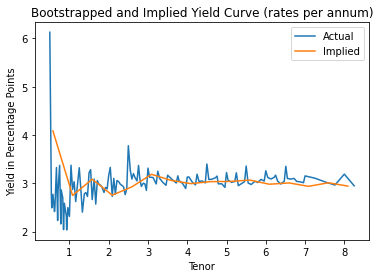

In [407]:
'''
Presents implied and actual yield curve as a plot
'''
shadow_ttm = ((shadow_px.index - datetime.datetime.now()) / datetime.timedelta(days=365)).to_list()
shadow_factors = shadow_px['shadow price'].to_list()
implied_rates = [-np.log(shadow_factors[i]) / shadow_ttm[i] for i in range(len(shadow_ttm))]

implied_rates_df = pd.DataFrame(
                        data = [shadow_ttm, implied_rates],
                        index=['ttm','implied_rate']
                    )

implied_rates_df = (implied_rates_df
                        .transpose()
                        .round({'ttm':round_to})
                        .set_index('ttm')
                    )

plt.plot(rates[0.5:8.5] * 100)
plt.plot(implied_rates_df * 100)
plt.title('Bootstrapped and Implied Yield Curve (rates per annum)')
plt.xlabel('Tenor')
plt.ylabel('Yield in Percentage Points')
plt.legend(['Actual', 'Implied'])

In [408]:
'''

'''

md(''' 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

{}

'''.format((implied_rates_df*100).to_markdown(colalign = ("right",)))
)

 
##### <center> Sensitivity Analysis - Shadow Prices  </center>

<center>

|   ttm |   implied_rate |
|------:|---------------:|
|  0.58 |        4.0837  |
|  1.08 |        2.74813 |
|  1.58 |        3.08269 |
|  2.09 |        2.75353 |
|  2.59 |        2.92491 |
|  3.09 |        3.18492 |
|  3.59 |        3.05877 |
|  4.09 |        2.99191 |
|  4.59 |        3.03297 |
|  5.09 |        3.03753 |
|  5.59 |        3.06566 |
|  6.09 |        2.9795  |
|  6.59 |        3.00627 |
|  7.09 |        2.93624 |
|  7.59 |        3.0092  |
|  8.09 |        2.94109 |



## Problem 5

Formulate a linear programming model to find the lowest cost bond immunized portfolio that matches the present value, duration, and convexity of a stream of liabilities. Assume that no short rates are allowed. What is the cost of your portfolio? How much would you save by using this immunization strategy instead of the dedication one? Is your portfolio immunized against non-parallel shifts in the term structure? Explain why or why not.

In [409]:
'''
Aggregates cashflow matrix and ref data for immunization
---
Puts cashflow matrix into a dataframe for merging
merges possible bond ref data with cashflow matrix
cleans resulting dataframe

NOTE: MATH NEEDS WORK HERE BUT WE CAN FIGURE OUT
from here: use ttm and col_num against calculated curve to find appropriate measure
        pv_factor = exp{-rt} = exp{- () * (ttm)}
'''

cf_df = pd.DataFrame(cf_matrix, index=dec_var_names.to_list())

cf_df = pd.merge(                                                           # Combines possible bonds with cashflow matrix
    left = possibilities,                                                   # possible bonds - SAME DF AS DEDICATION
    right = cf_df,                                                          # Cashflow matrix - NP ARRAY FROM DEDICATION AS DF FOR MERGING
    how='inner',                                                            # Catches any missed bonds on merge
    left_on='ref_data',                                                     # possibilities not indexed by bond name - CHAZ IS THIS SOMETHING WE CAN ADJUST OR NO?????????????????????
    right_index=True                                                        # Casflow df indexed by bond name
)

cf_df = (cf_df
            .drop(['COUPON','period','face'],axis=1)                        # Drops unnecessary ref data
            .set_index('ref_data')                                          # Sets index to bond name
            .round({'ttm':round_to})                                        # rounds time to maturity to 2 decimal places -- allows use of derived term structure (indexed by hundredths)
        )

cf_df

,px_ask,px_bid,ttm,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
ref_data,,,,,,,,,,,,,,,,,,,
T 1.75 05/15/22,100.010,100.004,-0.00,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 2.125 05/15/22,100.012,100.006,-0.00,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 0.0 05/17/22,99.352,99.342,0.00,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 0.0 05/19/22,99.340,99.330,0.01,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
T 0.0 05/24/22,99.320,99.310,0.02,100.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T 6.125 08/15/29,120.284,120.274,7.25,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,3.0625,103.0625,0.0000
T 1.75 11/15/29,92.076,92.066,7.51,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,0.8750,100.8750,0.0000
T 1.5 02/15/30,90.076,90.066,7.76,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,0.7500,100.7500


In [410]:
'''
Create Present Value, Duration, and Convexity factors for all possible time index based on derived rates curve
'''
t = rates.index
r = rates['rate']
npv_factor = np.exp(-r*t)
dur_factor = t*np.exp(-r*(t+1))
con_factor = t*(t+1)*np.exp(-r*(t+2))

In [411]:
'''
Calculates npv, duration, and convexity terms for all bonds consiuder in problem
'''
npvs=[]
durs=[]
cons=[]
for bond in cf_df.index:
    bond_df = cf_df.loc[bond]
    bond_ttm = bond_df.loc['ttm']
    bond_cf_stream = bond_df.loc[0:]
    eo_cfs = bond_cf_stream.idxmax()
    cpn_ttm = [(bond_ttm - 0.5*i).round(round_to) for i in range(eo_cfs+1)]
    bond_cf_ttm = pd.Series(data=bond_df.loc[0:eo_cfs].to_list(), index=reversed(cpn_ttm))

    bond_npv = sum([bond_cf_ttm.loc[i] * npv_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_dur = sum([bond_cf_ttm.loc[i] * dur_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_con = sum([bond_cf_ttm.loc[i] * con_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])

    npvs.append(bond_npv)
    durs.append(bond_dur)
    cons.append(bond_con)

immunization_df = pd.DataFrame([npvs, durs, cons], columns=cf_df.index, index=['npv','duration','convexity']).transpose()

In [412]:
immunization_df

,npv,duration,convexity
ref_data,,,
T 1.75 05/15/22,100.875000,0.000000,0.000000
T 2.125 05/15/22,101.062500,0.000000,0.000000
T 0.0 05/17/22,100.000000,0.000000,0.000000
T 0.0 05/19/22,99.214043,0.450700,0.206787
T 0.0 05/24/22,99.384158,1.459504,1.093110
...,...,...,...
T 6.125 08/15/29,120.792770,703.903617,5302.197198
T 1.75 11/15/29,91.211370,623.524879,5045.341563
T 1.5 02/15/30,90.077923,638.177521,5329.680741


In [413]:
'''
Solves immunization portfolio
'''
bond_count = LpVariable.dicts('Bonds',dec_var_names,lowBound=0)

immunization = LpProblem('immunization', LpMinimize)

immunization += lpSum([cf_df['px_ask'].loc[i] * bond_count[i] for i in dec_var_names])
immunization += lpSum([immunization_df['npv'].loc[i] * bond_count[i] for i in dec_var_names]) == npv
immunization += lpSum([immunization_df['duration'].loc[i] * bond_count[i] for i in dec_var_names]) == dur
immunization += lpSum([immunization_df['convexity'].loc[i] * bond_count[i] for i in dec_var_names]) == con

immunization.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/2ca107ef4a254ed1b963a12e397c533f-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/2ca107ef4a254ed1b963a12e397c533f-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 1159 RHS
At line 1163 BOUNDS
At line 1164 ENDATA
Problem MODEL has 3 rows, 289 columns and 861 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 3 (0) rows, 283 (-6) columns and 847 (-14) elements
0  Obj 0 Primal inf 101.059 (3)
14  Obj 116.81383
Optimal - objective value 116.81383
After Postsolve, objective 116.81383, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 116.8138298 - 14 iterations time 0.002, Pre

1

In [414]:
'''
Print Solution to Immunized portfolio
'''
bonds_fin = pd.DataFrame([[v.name[6:] for v in immunization.variables()], [v.varValue for v in immunization.variables()]], index=['bond','amt']).transpose().set_index('bond')
bonds_fin[bonds_fin['amt']>0]

md(''' 
##### <center> Portoflio Allocation - Immunization  </center>

<center> Immunized Portfolio Value of ${:.2f} MM  </center> <br>


<center>

{}

'''.format(value(immunization.objective), bonds_fin[bonds_fin['amt']>0].to_markdown(colalign = ("right",)))
)

 
##### <center> Portoflio Allocation - Immunization  </center>

<center> Immunized Portfolio Value of $116.81 MM  </center> <br>


<center>

|             bond |      amt |
|-----------------:|---------:|
| T_6.125_08_15_29 | 0.22514  |
| T_6.625_02_15_27 | 0.611911 |
|  T_7.25_08_15_22 | 0.184631 |



## Problem 6

Combine a cash matching strategy (dedication) for the liabilities for the first three years and an immunization strategy based on matching present value, duration and convexity for the liabilities during the last five years. Compare the characteristics of the three bond portfolios you have obtained. Explain which one you think is the best one and why.

In [415]:
'''
Immunization part
Calculates npv, duration, and convexity terms for all bonds considered in the problem
FROM period 7-16
'''

ded_period = 6
imm_period = 5
imm_start_period = len(data_prompt) - imm_period*2
imm_end_period = len(data_prompt)

npvs2=[]
durs2=[]
cons2=[]
for bond in cf_df.index:
    bond_df = cf_df.loc[bond]
    bond_ttm = bond_df.loc['ttm']
    bond_cf_stream = bond_df.loc[imm_start_period:]
    eo_cfs = bond_cf_stream.idxmax()
    cpn_ttm = [(bond_ttm - 0.5*i).round(round_to) for i in range(eo_cfs+1-imm_start_period)]
    bond_cf_ttm = pd.Series(data=bond_df.loc[imm_start_period:eo_cfs].to_list(), index=reversed(cpn_ttm))

    bond_npv = sum([bond_cf_ttm.loc[i] * npv_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_dur = sum([bond_cf_ttm.loc[i] * dur_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])
    bond_con = sum([bond_cf_ttm.loc[i] * con_factor.loc[:i].iloc[-1] for i in bond_cf_ttm.index])

    npvs2.append(bond_npv)
    durs2.append(bond_dur)
    cons2.append(bond_con)

immunization_df2 = pd.DataFrame([npvs2, durs2, cons2], columns=cf_df.index, index=['npv','duration','convexity']).transpose()

In [416]:
'''
Immunization part for Liabilities
Calculates npv, duration, and convexity of liabilities
FROM YEAR 1-3
'''



data_prompt2 = data_prompt
r2 = []
for ttm in data_prompt2['ttm']:
    r2.append(rates[:ttm].iloc[-1,0])
data_prompt2['rates'] = r2

npv2 = sum([data_prompt2.iloc[i,0]*np.exp((-1) * data_prompt2.iloc[i,1] * data_prompt2.iloc[i,2]) for i in range(imm_start_period, imm_end_period)])
dur2 = sum([data_prompt2.iloc[i,1]*data_prompt2.iloc[i,0]*np.exp((-1) * data_prompt2.iloc[i,1] * data_prompt2.iloc[i,2]) for i in range(imm_start_period, imm_end_period)])
con2 = sum([data_prompt2.iloc[i,1]*(data_prompt2.iloc[i,1]+1)*data_prompt2.iloc[i,0]*np.exp((-1) * (data_prompt2.iloc[i,1] + 2 ) * data_prompt2.iloc[i,2]) for i in range(imm_start_period, imm_end_period)])

print('The Net Present Value of the Liabilities is ${:.2f} million dollars'.format(npv2/1000))
print('The Macauley Duration of the Liability stream is {:.2f} years'.format(dur2/npv2))
print('The Convexity of the Liability stream is {:.2f}'.format(con2/npv2))


The Net Present Value of the Liabilities is $0.07 million dollars
The Macauley Duration of the Liability stream is 5.63 years
The Convexity of the Liability stream is 37.13


In [417]:
'''
Solves combined portfolio
'''
bond_q = LpVariable.dicts('Bond',dec_var_names,lowBound=0)
excess_cf = LpVariable.dicts('ExcessCf', periods[:ded_period+1], lowBound=0)


combined = LpProblem('Combined', LpMinimize)

combined += lpSum([cf_df['px_ask'][i] * bond_q[i] for i in dec_var_names]+ excess_cf[0]) 

for i in range(0,ded_period):
    combined += lpSum([cf_df[i][j]*bond_q[j] for j in dec_var_names]) + excess_cf[i]- excess_cf[i+1] == liabilities[i]

combined += lpSum([immunization_df['npv'][i] * bond_q[i] for i in dec_var_names]) == npv
combined += lpSum([immunization_df['duration'][i] * bond_q[i] for i in dec_var_names]) == dur
combined += lpSum([immunization_df['convexity'][i] * bond_q[i] for i in dec_var_names]) == con

combined.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/087472b4baa5437ab0fbef8ceb4c3521-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/087472b4baa5437ab0fbef8ceb4c3521-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 14 COLUMNS
At line 2297 RHS
At line 2307 BOUNDS
At line 2308 ENDATA
Problem MODEL has 9 rows, 296 columns and 1992 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 9 (0) rows, 291 (-5) columns and 1975 (-17) elements
0  Obj 0 Primal inf 156.45266 (9)
29  Obj 117.10344
Optimal - objective value 117.10344
After Postsolve, objective 117.10344, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 117.1034366 - 29 iterations time 0.002

1

In [418]:
'''
Print Solution to Combined portfolio
'''
bonds_comb = pd.DataFrame([[v.name[6:] for v in combined.variables()], [v.varValue for v in combined.variables()]], index=['bond','amt']).transpose().set_index('bond')
bonds_comb[bonds_comb['amt']>0]

md(''' 
##### <center> Portoflio Allocation - Combined  </center>

<center> Combined Portfolio Value of ${:.2f} MM  </center> <br>


<center>

{}

'''.format(value(combined.objective), bonds_comb[bonds_comb['amt']>0].to_markdown(colalign = ("right",)))
)

 
##### <center> Portoflio Allocation - Combined  </center>

<center> Combined Portfolio Value of $117.10 MM  </center> <br>


<center>

|            bond |       amt |
|----------------:|----------:|
| _0.125_12_15_23 | 0.0566625 |
|  _0.25_06_15_24 | 0.0466979 |
|  _1.75_05_15_23 | 0.0660842 |
|  _2.25_10_31_24 | 0.0667563 |
|   _5.5_08_15_28 | 0.35943   |
| _6.125_08_15_29 | 0.088369  |
| _6.375_08_15_27 | 0.217949  |
|  _7.25_08_15_22 | 0.0830729 |
| _7.625_02_15_25 | 0.0775073 |



## Problem 7

The municipality would like to make a second bid (find a different portfolio of bonds). What is your best dedicated portfolio of risk-free bonds you can create *if short sales are allowed*? Did you find arbitrage opportunities? Did you take into consideration the bid-ask spread of the bonds? How would you take them in consideration and what is the result? Did you set limits in the transaction amounts? Discuss the practical feasibility of your solutions.

## Without Transaction Limits

In [419]:
'''
Solves short portfolio
'''
short_limit = 0.5
long_q = LpVariable.dicts('Long',dec_var_names,lowBound=0)
short_q = LpVariable.dicts('Short',dec_var_names,lowBound=0)
excess_cfs = LpVariable.dicts('ExcessCf', periods, lowBound=0)

short = LpProblem('Short', LpMinimize)

#Objective 
short += lpSum([cf_df['px_ask'][i] * long_q[i] - cf_df['px_bid'][i] * short_q[i] for i in dec_var_names]+ excess_cfs[0]) 

#Bounds Objective to be NonNegative - Municipality can't profit from short trading - At best they get their dedication portfolio free
short += lpSum([cf_df['px_ask'][i] * long_q[i] - cf_df['px_bid'][i] * short_q[i] for i in dec_var_names]+ excess_cfs[0]) >= 0

#Liabilities Constraints
for i in range(0,len(cf_matrix[0])):
    short += lpSum([cf_df[i][j]*long_q[j] - cf_df[i][j]*short_q[j] for j in dec_var_names]) + excess_cfs[i] - excess_cfs[i+1] == liabilities[i]

short.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/a00975f8fd774d3797764b0184623834-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/a00975f8fd774d3797764b0184623834-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 22 COLUMNS
At line 4309 RHS
At line 4327 BOUNDS
At line 4328 ENDATA
Problem MODEL has 17 rows, 595 columns and 3707 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 17 (0) rows, 584 (-11) columns and 3676 (-31) elements
0  Obj 0 Primal inf 1.2899668 (16) Dual inf 1151796.9 (284)
0  Obj 0 Primal inf 1.2899668 (16) Dual inf 1.205329e+14 (294)
27  Obj -9.094947e-13
Optimal - objective value -9.094947e-13
After Postsolve, objective -9.094947e

1

In [420]:
'''
Print Solution to Short portfolio
'''
bonds_short = pd.DataFrame(
    [v.varValue for v in short.variables() if v.varValue != 0],
    index=[str(v.name[:-8].replace('_', ' ')+v.name[-8:].replace('_', '/')) for v in short.variables() if v.varValue != 0],
    columns=['Quantity']
    )

md(''' 
##### <center> Portoflio Allocation - Dedication with Short  </center>

<center> Portfolio Value of ${:.2f} MM  </center> <br>

<center>

{}

'''.format(value(short.objective)*1000000, bonds_short[bonds_short['Quantity']!=0].to_markdown(colalign = ("right",)))
)

 
##### <center> Portoflio Allocation - Dedication with Short  </center>

<center> Portfolio Value of $-79.20 MM  </center> <br>

<center>

|                        |     Quantity |
|-----------------------:|-------------:|
|             ExcessCf/3 | -1.38988e-09 |
|             ExcessCf/6 |  7.49844     |
|   Long T 0.75 05/31/26 |  0.104984    |
|    Long T 1.5 11/30/24 |  0.0685951   |
|    Long T 2.0 05/31/24 |  0.0481139   |
|  Long T 2.875 05/15/28 |  0.0607689   |
|   Long T 5.25 02/15/29 |  0.0638876   |
|    Long T 5.5 08/15/28 |  0.0816424   |
|  Long T 6.125 08/15/29 |  0.0755646   |
|   Long T 6.25 05/15/30 |  0.0678788   |
|   Long T 6.25 08/15/23 |  0.0563529   |
|  Long T 6.375 08/15/27 |  0.0395095   |
|  Long T 6.625 02/15/27 |  0.0479221   |
|   Long T 6.75 08/15/26 |  0.0753781   |
|  Long T 7.125 02/15/23 | 61.1449      |
|  Long T 7.625 02/15/25 |  0.154094    |
|   Short T 0.0 06/16/22 |  2.04863     |
| Short T 0.137 12/31/22 | 63.2136      |



## With Transaction Limits

In [421]:
'''
Solves short portfolio with a Shorting Limit
'''
short_limit = 0.3
long_q = LpVariable.dicts('Long',dec_var_names,lowBound=0)
short_q = LpVariable.dicts('Short',dec_var_names,lowBound=0)
excess_cfs = LpVariable.dicts('ExcessCf', periods, lowBound=0)

short_l = LpProblem('Short', LpMinimize)

#Objective 
short_l += lpSum([cf_df['px_ask'][i] * long_q[i] - cf_df['px_bid'][i] * short_q[i] for i in dec_var_names]+ excess_cfs[0]) 

#Bounds Objective to be Positive - Municipality can't profit from short trading - At best they get their dedication portfolio free
short_l += lpSum([cf_df['px_ask'][i] * long_q[i] - cf_df['px_bid'][i] * short_q[i] for i in dec_var_names]+ excess_cfs[0]) >= 0

#Adds a Short Limit as a % of the Total Amount invested in Long Bonds
short_l += lpSum([cf_df['px_bid'][i] * short_q[i] for i in dec_var_names]) <= lpSum([cf_df['px_ask'][i] * long_q[i] for i in dec_var_names])*short_limit

#Liabilities Constraints
for i in range(0,len(cf_matrix[0])):
    short_l += lpSum([cf_df[i][j]*long_q[j] - cf_df[i][j]*short_q[j] for j in dec_var_names]) + excess_cfs[i] - excess_cfs[i+1] == liabilities[i]

short_l.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/a5b3e50041884d87a390ed23670c20ed-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/a5b3e50041884d87a390ed23670c20ed-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 23 COLUMNS
At line 4888 RHS
At line 4907 BOUNDS
At line 4908 ENDATA
Problem MODEL has 18 rows, 595 columns and 4285 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 18 (0) rows, 584 (-11) columns and 4244 (-41) elements
0  Obj 0 Primal inf 1.2899668 (16) Dual inf 1151796.9 (284)
0  Obj 0 Primal inf 1.2899668 (16) Dual inf 1.205329e+14 (294)
31  Obj 116.84348
Optimal - objective value 116.84348
After Postsolve, objective 116.84348, infeasi

1

In [422]:
'''
Print Solution to Short portfolio with Shorting Limit
'''
bonds_short_l = pd.DataFrame(
    [v.varValue for v in short_l.variables() if v.varValue != 0],
    index=[str(v.name[:-8].replace('_', ' ')+v.name[-8:].replace('_', '/')) for v in short_l.variables() if v.varValue != 0],
    columns=['Quantity']
    )

md(''' 
##### <center> Portoflio Allocation - Dedication with Short Limits  </center>

<center> Portfolio Value of ${:.2f} MM  </center> <br>

<center>

{}

'''.format(value(short_l.objective), bonds_short_l[bonds_short_l['Quantity']!=0].to_markdown(colalign = ("right",)))
)

 
##### <center> Portoflio Allocation - Dedication with Short Limits  </center>

<center> Portfolio Value of $116.84 MM  </center> <br>

<center>

|                        |     Quantity |
|-----------------------:|-------------:|
|             ExcessCf/3 | -1.38988e-09 |
|  Long T 0.625 05/15/30 |  0.0697819   |
|   Long T 0.75 05/31/26 |  0.107674    |
|   Long T 1.25 05/31/28 |  0.0637436   |
|    Long T 1.5 11/30/24 |  0.0714316   |
|    Long T 2.0 05/31/24 |  0.0509223   |
|  Long T 2.875 04/30/29 |  0.0664559   |
|    Long T 5.5 08/15/28 |  0.084142    |
|  Long T 6.125 08/15/29 |  0.0774112   |
|   Long T 6.25 08/15/23 |  0.558836    |
|  Long T 6.375 08/15/27 |  0.0423924   |
|  Long T 6.625 02/15/27 |  0.0507125   |
|   Long T 6.75 08/15/26 |  0.0780774   |
|  Long T 6.875 08/15/25 |  0.0750923   |
|  Long T 7.125 02/15/23 |  0.0519306   |
|   Long T 7.25 08/15/22 |  0.0694143   |
|  Long T 7.625 02/15/25 |  0.0819673   |
| Short T 0.125 06/30/23 |  0.515056    |



## Problem 8

Consider proposing a new portfolio of bonds using any additional consideration or change to the model that you see fit. For example, can you do something to make your portfolio of bonds immune to nonparallel changes in the term structure. Is there a better way to combine the techniques you used before. Explain clearly what you do and your results.

In [424]:
'''
Immunization With Shorting Available
'''


long_q = LpVariable.dicts('Long',dec_var_names,lowBound=0)
short_q = LpVariable.dicts('Short',dec_var_names,lowBound=0)



imm_s = LpProblem('Immunized_Short', LpMinimize)

imm_s += lpSum([cf_df['px_bid'][i] * short_q[i] for i in dec_var_names]) <= lpSum([cf_df['px_ask'][i] * long_q[i] for i in dec_var_names])*short_limit

imm_s += lpSum([cf_df['px_ask'][i] * long_q[i] - cf_df['px_bid'][i] * short_q[i] for i in dec_var_names])
imm_s += lpSum([immunization_df['npv'].loc[i] * long_q[i] - immunization_df['npv'].loc[i] * short_q[i] for i in dec_var_names]) == npv
imm_s += lpSum([immunization_df['duration'].loc[i] * long_q[i] - immunization_df['duration'].loc[i] * short_q[i] for i in dec_var_names]) == dur
imm_s += lpSum([immunization_df['convexity'].loc[i] * long_q[i] - immunization_df['convexity'].loc[i] * short_q[i] for i in dec_var_names]) == con

imm_s.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/rodrigopetricioli/Library/Python/3.9/lib/python/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/f492f0ee12834998b602eb5b132cb156-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/zl/vg5hkklj0c3gbf3hsqbpqp380000gn/T/f492f0ee12834998b602eb5b132cb156-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 9 COLUMNS
At line 2888 RHS
At line 2893 BOUNDS
At line 2894 ENDATA
Problem MODEL has 4 rows, 578 columns and 2300 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve 4 (0) rows, 576 (-2) columns and 2292 (-8) elements
0  Obj 0 Primal inf 100.67723 (3) Dual inf 89332.853 (288)
0  Obj 0 Primal inf 100.67723 (3) Dual inf 8.9021204e+13 (288)
11  Obj 115.18831
Optimal - objective value 115.18831
After Postsolve, objective 115.18831, infeasibiliti

1

In [425]:
'''
Print Solution to Short Immunized portfolio
'''
imms_bonds = pd.DataFrame(
    [v.varValue for v in imm_s.variables() if v.varValue != 0],
    index=[str(v.name[:-8].replace('_', ' ')+v.name[-8:].replace('_', '/')) for v in imm_s.variables() if v.varValue != 0],
    columns=['Quantity']
    )

md(''' 
##### <center> Portoflio Allocation - Dedication with Short Limits  </center>

<center> Portfolio Value of ${:.2f} MM  </center> <br>

<center>

{}

'''.format(value(imm_s.objective), imms_bonds[imms_bonds['Quantity']!=0].to_markdown(colalign = ("right",)))
)

 
##### <center> Portoflio Allocation - Dedication with Short Limits  </center>

<center> Portfolio Value of $115.19 MM  </center> <br>

<center>

|                        |   Quantity |
|-----------------------:|-----------:|
|  Long T 6.125 08/15/29 |   0.194729 |
|  Long T 6.625 02/15/27 |   0.683834 |
|   Long T 7.25 08/15/22 |   0.610069 |
| Short T 7.625 11/15/22 |   0.479165 |

